In [9]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC, SVR

## Load data

In [10]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
# y_test = np.load("y_test.npy")

In [11]:
# 7000 data with 300 features
print(x_train.shape)
print(y_train.shape)

(7000, 300)
(7000,)


In [12]:
# It's a binary classification problem 
print(np.unique(y_train))

[0 1]


In [13]:
# Function test
rng = np.random.default_rng()
print(rng.choice(5, 5, replace=False))
print(rng.choice(x_train, x_train.shape[0], replace=False).shape)
test = rng.choice(9, size=(3,3), replace=False)
print(test)
rng.permutation(test)
print(100//10)
xs = [22, 13, 45, 50, 98, 69, 43, 44, 1]
test = [x+1 if x >= 45 else x+5 for x in xs]

[3 0 1 4 2]
(7000, 300)
[[3 8 2]
 [0 4 1]
 [7 6 5]]
10


## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [14]:
rng = np.random.default_rng()
def cross_validation(x_train, y_train, k=5):
    # shuffle the data
    shuf_idx = rng.permutation(x_train.shape[0])
    print(np.unique(shuf_idx).shape)
    # find the size of each fold
    all_size = np.array([(x_train.shape[0] // k) + 1 if i < x_train.shape[0] % k else x_train.shape[0] // k for i in range(k)])
    all_split = []
    for i in range(k):
        val_idx   = shuf_idx[np.sum(all_size[0:i]):np.sum(all_size[0:(i+1)])]
        mask = np.isin(shuf_idx, val_idx, invert=True)
        # print(mask.shape)
        train_idx = shuf_idx[mask]
        all_split.append([])
        all_split[i].append(train_idx)
        all_split[i].append(val_idx)
    return all_split

In [23]:
kfold_data = cross_validation(x_train, y_train, k=10)
for i, (train_index, val_index) in enumerate(kfold_data):
    print("Split: %s, Training index: %s, Validation index: %s" % (i+1, len(train_index), len(val_index)))
assert len(kfold_data) == 10 # should contain 10 fold of data
assert len(kfold_data[0]) == 2 # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 700 # The number of data in each validation fold should equal to training data divieded by K

(7000,)
Split: 1, Training index: 6300, Validation index: 700
Split: 2, Training index: 6300, Validation index: 700
Split: 3, Training index: 6300, Validation index: 700
Split: 4, Training index: 6300, Validation index: 700
Split: 5, Training index: 6300, Validation index: 700
Split: 6, Training index: 6300, Validation index: 700
Split: 7, Training index: 6300, Validation index: 700
Split: 8, Training index: 6300, Validation index: 700
Split: 9, Training index: 6300, Validation index: 700
Split: 10, Training index: 6300, Validation index: 700


## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C” and “gamma” to find the best parameters by cross-validation.

In [16]:
# Train with k=5
kfold_data = cross_validation(x_train, y_train, k=5)
for i, (train_index, val_index) in enumerate(kfold_data):
    print("Split: %s, Training index: %s, Validation index: %s" % (i+1, len(train_index), len(val_index)))
assert len(kfold_data) == 5 # should contain 5 fold of data
assert len(kfold_data[0]) == 2 # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 1400 # The number of data in each validation fold should equal to training data divieded by K

(7000,)
Split: 1, Training index: 5600, Validation index: 1400
Split: 2, Training index: 5600, Validation index: 1400
Split: 3, Training index: 5600, Validation index: 1400
Split: 4, Training index: 5600, Validation index: 1400
Split: 5, Training index: 5600, Validation index: 1400


In [17]:
clf = SVC(C=1.0, kernel='rbf', gamma=0.01)

In [18]:
## your code
grid_C = [1, 1e1, 1e2, 1e3, 1e4]
# print(grid_C)
grid_G = [1e-5, 2e-5, 4e-5, 6e-5, 8e-5, 1e-4]
# print(grid_G)
# for i, (train_index, val_index) in enumerate(kfold_data):
#     print("Split: %s, Training index: %s, Validation index: %s" % (i+1, len(train_index), len(val_index)))
#     # print("%s, %s" % (np.unique(np.array(train_index)).shape, np.unique(np.array(val_index)).shape))
best_acc = 0
best_parameters = None
stat_table = []
for idx in range(len(grid_C)):
    t = []
    c_t = grid_C[idx]
    for g_t in grid_G:
        clf = SVC(C=c_t, kernel='rbf', gamma=g_t)
        temp_acc = 0
        for i, (train_index, val_index) in enumerate(kfold_data):
            x_train_t = x_train[train_index]
            y_train_t = y_train[train_index]
            clf.fit(x_train_t, y_train_t)
            x_test_t = x_train[val_index]
            y_test_t = y_train[val_index]
            y_pred_t = clf.predict(x_test_t)
            temp_acc += accuracy_score(y_true=y_test_t, y_pred=y_pred_t)
        temp_acc = temp_acc / len(kfold_data)
        t.append(temp_acc)
        if temp_acc >= best_acc:
            best_parameters = {'C': c_t, 'Gamma': g_t, 'kernel': 'rbf'}
    stat_table.append(t)

In [19]:
print(len(kfold_data))
print(best_parameters)
# print(stat_table)

5
{'C': 10000.0, 'Gamma': 0.0001, 'kernel': 'rbf'}


## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like this reference image below ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

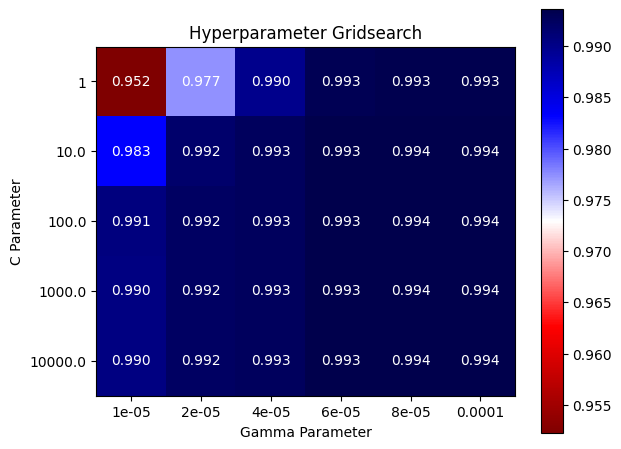

In [20]:
def heatmap(data, row_labels, col_labels, ax=None, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    ax.set_xlabel('Gamma Parameter')
    ax.set_ylabel('C Parameter')

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
             rotation_mode="anchor")

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}", **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    data = im.get_array()

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center", verticalalignment="center")

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color='white')
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


fig, ax = plt.subplots()
im, cbar = heatmap(np.array(stat_table), grid_C, grid_G, ax=ax, cmap='seismic_r')
texts = annotate_heatmap(im, valfmt='{x:.3f}')
plt.title('Hyperparameter Gridsearch')
fig.tight_layout()
plt.show()

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set.

In [21]:
print(best_parameters)
best_model = SVC(C=best_parameters['C'], gamma=best_parameters['Gamma'], kernel='rbf')
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)
print("Accuracy score: ", accuracy_score(y_pred, y_test))

{'C': 10000.0, 'Gamma': 0.0001, 'kernel': 'rbf'}


NameError: name 'y_test' is not defined